# Composite-Adv Demonstration
![CAA Flow](figures/CAA_Flow.png)
This notebook provides a step-by-step demonstration showing how to launch our composite adversarial attack (CAA). We use the CIFAR-10 dataset for demonstration, while other datasets could be executed similarly.

## I. Parameters Configuration

In [1]:
PARAMS = {
    'seed': 0,
    'dataset': {
        'name': 'cifar10',
        'root': '../data/',
        'batch_size': 128,
        'normalize': {
            # CIFAR10
            'mean': [0.4914, 0.4822, 0.4465],
            'std': [0.2023, 0.1994, 0.2010],
            # ImageNet
            # 'mean': [0.485, 0.456, 0.406],
            # 'std': [0.229, 0.224, 0.225],
        }
    },
    'model':{ 
        'madry':{ # Madry's Robust Model
            'arch': 'resnet50',
            'normalize': True,
            'checkpoint': '../GAT/pretrained_model/cifar_madry_resnet50_linf_8.pt', # download from https://github.com/MadryLab/robustness
        },
        'trades':{ # Trades' Robust Model
            'arch': 'wideresnet',
            'normalize': False,
            'checkpoint': '../GAT/pretrained_model/cifar_trades_wideresnet34_10_linf_8.pt', # download from https://github.com/yaodongyu/TRADES
        },
    },
}

In [2]:
import torch, numpy, random
torch.manual_seed(PARAMS['seed'])
numpy.random.seed(PARAMS['seed'])
random.seed(PARAMS['seed'])
torch.backends.cudnn.deterministic = True

## II. Dataset

In [3]:
from composite_adv.utilities import make_dataloader
# load dataset
data_loader = make_dataloader(PARAMS['dataset']['root'], PARAMS['dataset']['name'], transform=None, batch_size=PARAMS['dataset']['batch_size'], shuffle=True)

Files already downloaded and verified


## III. Select Models

### 1. Madry's $\ell_\infty$-robust model

In [4]:
from composite_adv.utilities import make_madry_model, EvalModel
# load model
base_model = make_madry_model(PARAMS['model']['madry']['arch'],
                              PARAMS['dataset']['name'],
                              checkpoint_path=PARAMS['model']['madry']['checkpoint'])

# Normalizer
model = EvalModel(base_model,
                  normalize_param=PARAMS['dataset']['normalize'],
                  input_normalized=PARAMS['model']['madry']['normalize'])

# Send to GPU
import torch
if not torch.cuda.is_available():
    print('using CPU, this will be slow')
else:
    model.cuda()

=> loaded checkpoint '../GAT/pretrained_model/cifar_madry_resnet50_linf_8.pt' (epoch 153)
Natural accuracy --> 87.02999877929688
Robust accuracy --> 55.029998779296875


### 2. TRADES $\ell_\infty$-robust model

In [4]:
from composite_adv.utilities import make_trades_model, EvalModel
# load model
base_model = make_trades_model(PARAMS['model']['trades']['arch'],
                               PARAMS['dataset']['name'],
                               checkpoint_path=PARAMS['model']['trades']['checkpoint'])

# Normalizer
model = EvalModel(base_model,
                  normalize_param=PARAMS['dataset']['normalize'],
                  input_normalized=PARAMS['model']['trades']['normalize'])

# Send to GPU
import torch
if not torch.cuda.is_available():
    print('using CPU, this will be slow')
else:
    model.cuda()

=> loaded checkpoint '../GAT/pretrained_model/cifar_trades_wideresnet34_10_linf_8.pt'


## IV. Evaluate Clean Accuracy

In [ ]:
from composite_adv.utilities import robustness_evaluate
from composite_adv.attacks import NoAttack

attack = NoAttack()
robustness_evaluate(model, attack, data_loader)

## V. Evaluate Robust Accuracy

**CAA Configuration**
1. Attacks Pool Selection. For simpilicity, we use the following abbreviations to specify each attack types.
   `0`: Hue, `1`: Saturation, `2`: Rotation, `3`: Brightness, `4`: Contrast, `5`: $\ell_\infty$

2. Attack Ordering Specify. We provide three ordering options ['fixed','random','scheduled']

**Setup**
```python
from composite_adv.attacks import CompositeAttack
CompositeAttack(model, dataset=PARAMS['dataset']['name'], enabled_attack=(0,), order_schedule="fixed")
```

In [ ]:
from composite_adv.attacks import CompositeAttack
from composite_adv.utilities import robustness_evaluate

###  1. Single Attack $\text{CAA}_\text{Hue}$

In [ ]:
composite_attack = CompositeAttack(model, # The model to be attacked
                                   dataset=PARAMS['dataset']['name'],
                                   enabled_attack=(0,), # Abbr: 0: Hue, 1: Saturation, 2: Rotation, 3: Brightness, 4: Contrast, 5: L-infinity
                                   order_schedule="fixed") # Three ordering options ['fixed','random','scheduled']
robustness_evaluate(model, composite_attack, data_loader)

### 2. Three Attacks $\text{CAA}_{3a}$ (Scheduled Order)

In [ ]:
composite_attack = CompositeAttack(model,
                                   dataset=PARAMS['dataset']['name'],
                                   enabled_attack=(0,1,5),
                                   order_schedule="scheduled")
robustness_evaluate(model, composite_attack, data_loader)

### 3. Semantic Attacks (Random Order)

In [ ]:
composite_attack = CompositeAttack(model,
                                   dataset=PARAMS['dataset']['name'],
                                   enabled_attack=(0,1,2,3,4),
                                   order_schedule="random")
robustness_evaluate(model, composite_attack, data_loader)

### 4. Full Attacks (Scheduled Order)

In [ ]:
composite_attack = CompositeAttack(model,
                                   dataset=PARAMS['dataset']['name'],
                                   enabled_attack=(0,1,2,3,4,5),
                                   order_schedule="scheduled")
robustness_evaluate(model, composite_attack, data_loader)

In [30]:
import csv

model_name = ['nat', 'linf8', 'gat-f']
all_model_acc = []
for j in range(len(model_name)):
    file_name = './saved/cifar10-' + model_name[j] + '-ood-attack.csv'
    corr_acc = []
    all_corr_name = []
    with open(file_name, mode ='r')as file:
        # reading the CSV file
        csvFile = csv.reader(file)
        # displaying the contents of the CSV file
        for lines in csvFile:
            if lines[0] == 'corruption_type':
                for i in range(1, len(lines)):
                    all_corr_name.append(lines[i])    
            if lines[0] == 'accuracies':
                for i in range(1, len(lines)):
                    corr_acc.append(float(lines[i])*100.0)
        corr_acc = corr_acc[0:7]  + corr_acc[8:11] + corr_acc[13:16] 
        corr_acc.reverse()
        print(corr_acc)
        all_model_acc.append(corr_acc)

[46.11999988555908, 74.00000095367432, 75.23000240325928, 76.98000073432922, 68.4499979019165, 78.39000225067139, 49.2000013589859, 55.400002002716064, 62.73000240325928, 68.05999875068665, 26.94999873638153, 38.80999982357025, 32.60999917984009]
[82.88000226020813, 84.07999873161316, 79.90000247955322, 38.22999894618988, 77.66000032424927, 80.0100028514862, 77.920001745224, 77.52000093460083, 80.12999892234802, 74.88999962806702, 65.47999978065491, 77.41000056266785, 77.20999717712402]
[78.17000150680542, 79.61999773979187, 75.20999908447266, 40.549999475479126, 75.78999996185303, 75.94000101089478, 72.50999808311462, 74.55999851226807, 76.82999968528748, 71.25999927520752, 52.920001745224, 70.35999894142151, 70.52000164985657]


In [16]:
all_corr_name = all_corr_name[0:7] + all_corr_name[8:11] + all_corr_name[13:16]
all_corr_name.reverse()
print(all_corr_name)
print(len(all_model_acc[0]))

['pixelate', 'jpeg_compression', 'elastic_transform', 'fog', 'frost', 'snow', 'glass_blur', 'defocus_blur', 'zoom_blur', 'motion_blur', 'impulse_noise', 'shot_noise', 'gaussian_noise']
13


In [40]:
print(np.array(all_model_acc[2][0:3]).mean())
print(np.array(all_model_acc[2][3:6]).mean())
print(np.array(all_model_acc[2][6:10]).mean())
print(np.array(all_model_acc[2][10:13]).mean())

77.66666611035664
64.09333348274231
73.78999888896942
64.60000077883403


['pixelate', 'jpeg_compression', 'elastic_transform', 'fog', 'frost', 'snow', 'glass_blur', 'defocus_blur', 'zoom_blur', 'motion_blur', 'impulse_noise', 'shot_noise', 'gaussian_noise']


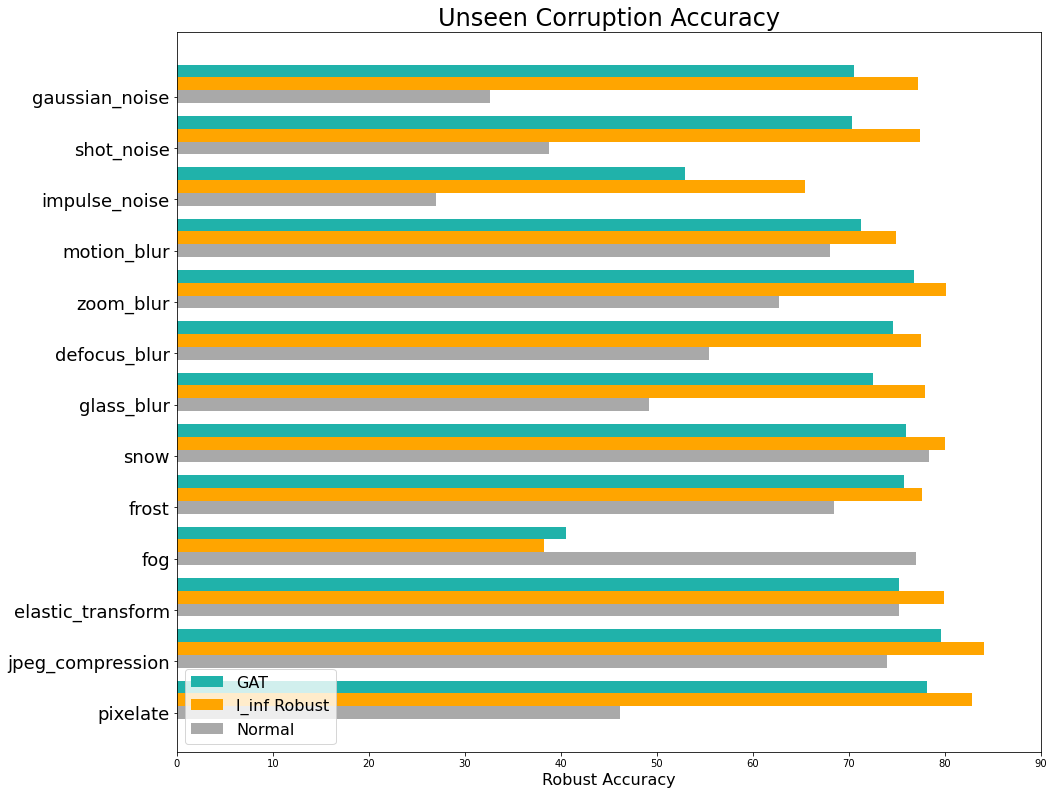

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
print(all_corr_name)
X = np.arange(13)
fig = plt.figure(figsize=(12,10))
ax = fig.add_axes([0,0,1,1])
ax.barh(X + 0.50, all_model_acc[2], color = 'lightseagreen', height = 0.25)
ax.barh(X + 0.25, all_model_acc[1], color = 'orange', height = 0.25)
ax.barh(X + 0.00, all_model_acc[0], color = 'darkgray', height = 0.25)
ax.set_xlabel('Robust Accuracy',fontsize=16)
ax.set_title('Unseen Corruption Accuracy', fontsize=24)
ax.set_xticks(np.arange(0, 100, 10))
ax.set_yticks(np.arange(0, 13, 1))
ax.set_yticklabels(all_corr_name, rotation=0, fontsize=18)
ax.legend(labels=['GAT', 'l_inf Robust', 'Normal'], fontsize=16, loc='lower left')
plt.savefig('ood_result.png', dpi=200)

['No Attack', 'Three Attacks', 'Semantic Attacks', 'Full Attacks']


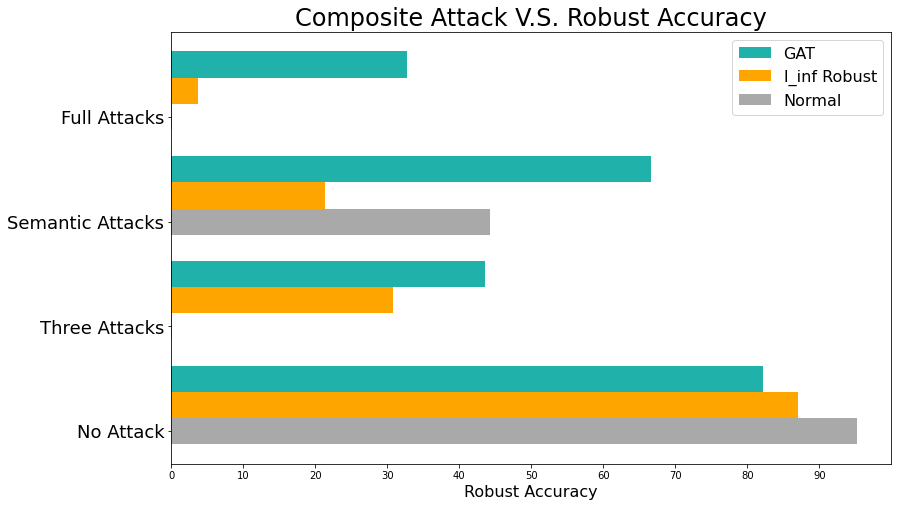

In [29]:
GAT_result = [82.1, 43.5, 66.6, 32.8]
Linf8_result = [87.0, 30.8, 21.3, 3.7]
Normal_result = [95.2, 0.1, 44.2, 0.1]
all_attack_name = ['No Attack', 'Three Attacks', 'Semantic Attacks', 'Full Attacks']
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
print(all_attack_name)
X = np.arange(4)
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0,0,1,1])
ax.barh(X + 0.50, GAT_result, color = 'lightseagreen', height = 0.25)
ax.barh(X + 0.25, Linf8_result, color = 'orange', height = 0.25)
ax.barh(X + 0.00, Normal_result, color = 'darkgray', height = 0.25)
ax.set_xlabel('Robust Accuracy',fontsize=16)
ax.set_title('Composite Attack V.S. Robust Accuracy', fontsize=24)
ax.set_xticks(np.arange(0, 100, 10))
ax.set_yticks(np.arange(0, 4, 1))
ax.set_yticklabels(all_attack_name, rotation=0, fontsize=18)

ax.legend(labels=['GAT', 'l_inf Robust', 'Normal'], fontsize=16, loc='upper right')
plt.savefig('compostie_result_v2.png', dpi=200)